# Trabajo Práctico 2:  Selección de Variables
## Natalia Mellino

In [5]:
# Imports

install.packages("gtools") ## Uncomment if not already installed
install.packages("randomForest")
install.packages("kernlab")
library(gtools)
library(RColorBrewer)
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Código de ejemplo dado

In [6]:
#-------------------------------------------------------------------------------------
# AVISO: este codigo esta adaptado de un paquete mayor. 
# No es optimo y tiene cosas inutiles para nosotros. Es un ejemplo nada mas
#
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]
	num.feat<-1
	list.feat<-1:max.feat

	#ranking inicial: elijo la variable con menor error de prediccion
    x.train<-matrix(0,dim(x)[1],1)
	class.error<-double(max.feat)
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train[,1]<-x[,i]
		class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
	}
	#guardo la variable con minimo error como primera. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]
	#armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]])
			class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]]
	}


	search.names<-colnames(x)[list.feat]
	#le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )

}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#filter con kruskal esta en las slides


library(randomForest)
library(kernlab)
library(MASS)

#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")


#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#datosA
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

#datosB
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos



## Ejercicio 1
### Wrapper greedy backward

In [7]:
backward.ranking <- function(x, y, method, ...){

    max.feat = dim(x)[2]
	list.feat = 1 : max.feat
	keep.feat = double(max.feat)
	  
	# Iteraremos hasta que eliminemos todos los features menos 1

	while(length(list.feat) > 1){
		class.error = double(length(list.feat))
		# Entrenamos y medimos el error para cada modelo sacando de a una feature a la vez
		for(i in 1 : length(list.feat)){
			x.train = as.matrix(x[, list.feat[-i]])
			class.error[i] = do.call(method, c(list(x.train, y), list(...)))
		}
		
		# Eliminamos el feature que nos da menos error al sacarlo (es el menos importante)
		min.index = which.min(class.error)
		keep.feat[length(list.feat)] = list.feat[min.index]
		list.feat = list.feat[- min.index]
	}
	
	# El último feature en eliminar es el que haya quedado de las iteraciones anteriores.
	keep.feat[1] = list.feat[1]
	
	# Preparamos la info
	search.names = colnames(x)[keep.feat]
	imp = (max.feat : 1) / max.feat
	names(imp) = search.names
	
 	return(list(ordered.names.list = search.names, 
 	            ordered.features.list = keep.feat, 
 	            imp = imp))

}

###  Filter con test no-paramétrico (Kruskal-Wallis)

In [8]:
kruskal.ranking <- function(x, y){
    
    size <- dim(x)[2]
    ranking <- c()
    for(i in 1 : size){
        feature <- x[, i]
        value <- kruskal.test(feature, y)$statistic
        ranking[i] <- value 
    }

    # Preparamos la info
    ranking <- sort(ranking, decreasing=TRUE, index=T)$ix
	
    search.names = colnames(x)[ranking]

	imp = (size : 1) / size
	names(imp) = search.names
	
    
 	
    return(list(ordered.names.list = search.names, 
 	            ordered.features.list = ranking, 
 	            imp = imp))

    
}

### RFE

In [9]:
rfe.ranking <- function(x, y, method, ...){

    size <- dim(x)[2]
    ranking <- 1 : size
    features <- 1 : size

    for(i in 1 : size){
        train.data <- as.matrix(x[, features])
        rank <- do.call(method, c(list(train.data, y), list(...)) )

        last.ranked <- rank$feats[1]
        
        ranking[size - i + 1] <- features[last.ranked]
        features <- features[-last.ranked]
    }

    # Preparamos la info
	search.names = colnames(x)[ranking]
	imp = (size : 1) / size
	names(imp) = search.names
	
 	return(list(ordered.names.list = search.names, 
 	            ordered.features.list = ranking, 
 	            imp = imp))
}

## Ejercicio 2

In [15]:
# Funcion auxiliar para mostrar las variables ordenadas en el ploteado
ordernar_nombres <- function(names, values){
    indexes <- mixedorder(names)
    sorted.values <- 1:length(indexes)
    iterator <- 1
    for(i in indexes){
        sorted.values[iterator] <- values[i]
        iterator <- iterator + 1
    }

    return(list(ordered.names=mixedsort(names), ordered.values=sorted.values))
}


In [18]:
# Funcion para graficar la importancia de las variables
graficar_valores <- function(datos, titulo="Plot"){
    datos_ordenados <- ordernar_nombres(datos$ordered.names.list, unname(datos$imp))
    names <- datos_ordenados$ordered.names
    importance <- datos_ordenados$ordered.values
    coul <- brewer.pal(5, "Set2")
    barplot(height=importance, names=names, col=coul, main=titulo, las=2)
}

In [ ]:
datosA.x = datosA[, -11]
datosA.y = datosA[, 11]
datosB.x = datosB[, -9]
datosB.y = datosB[, 9] 

### Backward ranking con distintas funciones

#### Dataset A

In [ ]:
# LDA
datos.lda <- backward.ranking(datosA.x, datosA.y, method="lda.est")
# SVM
invisible(capture.output(datos.svm <- backward.ranking(datosA.x, datosA.y, method="svm.est")))
# Random Forest
datos.bw <- backward.ranking(datosA.x, datosA.y, method="rf.est")

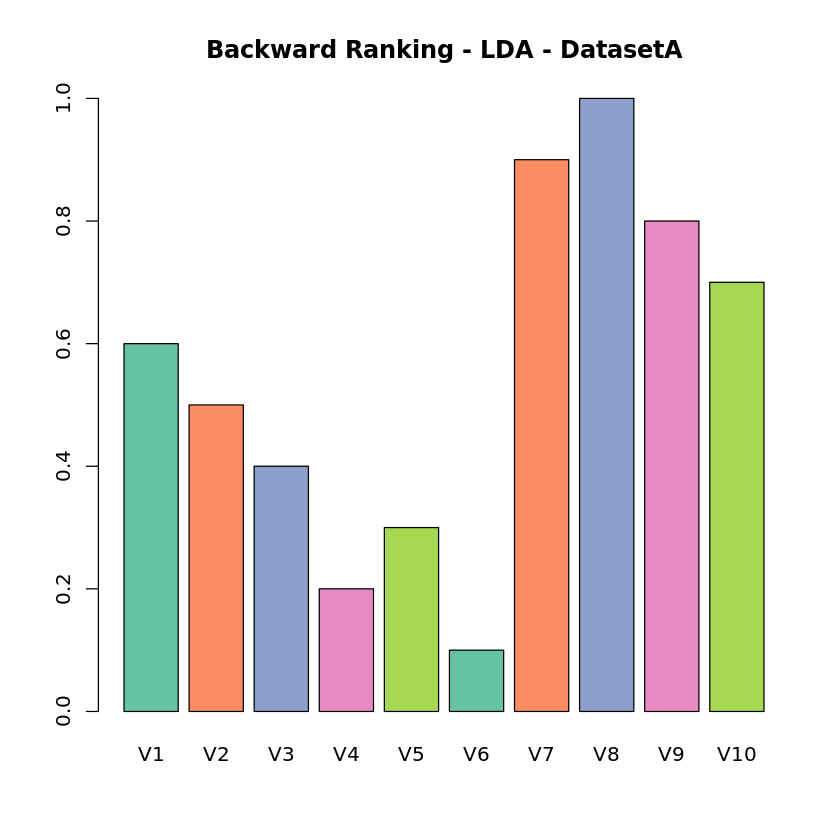

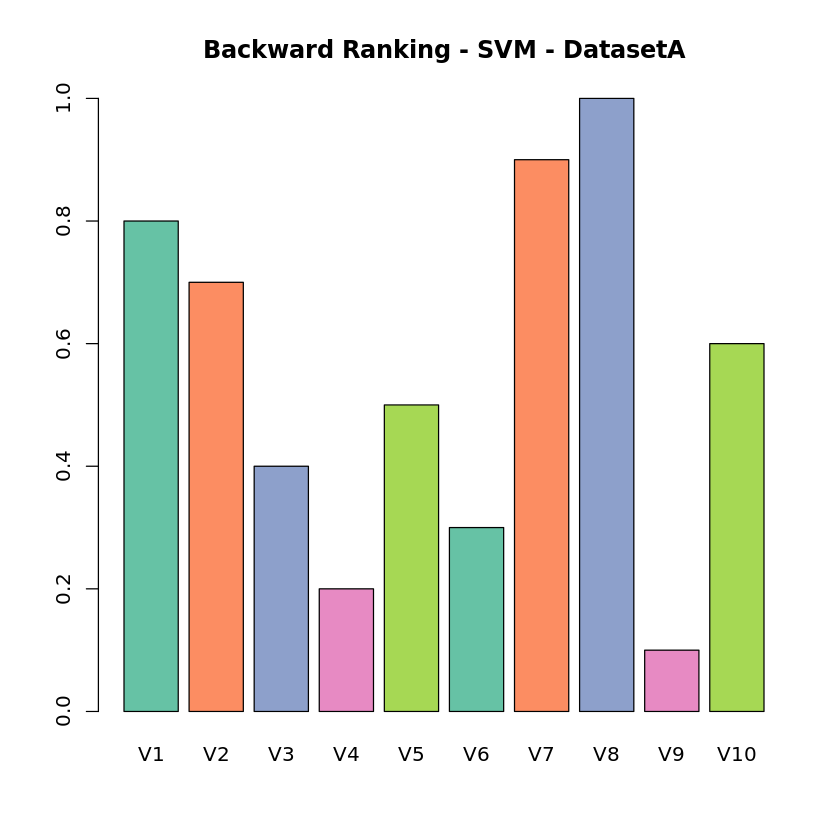

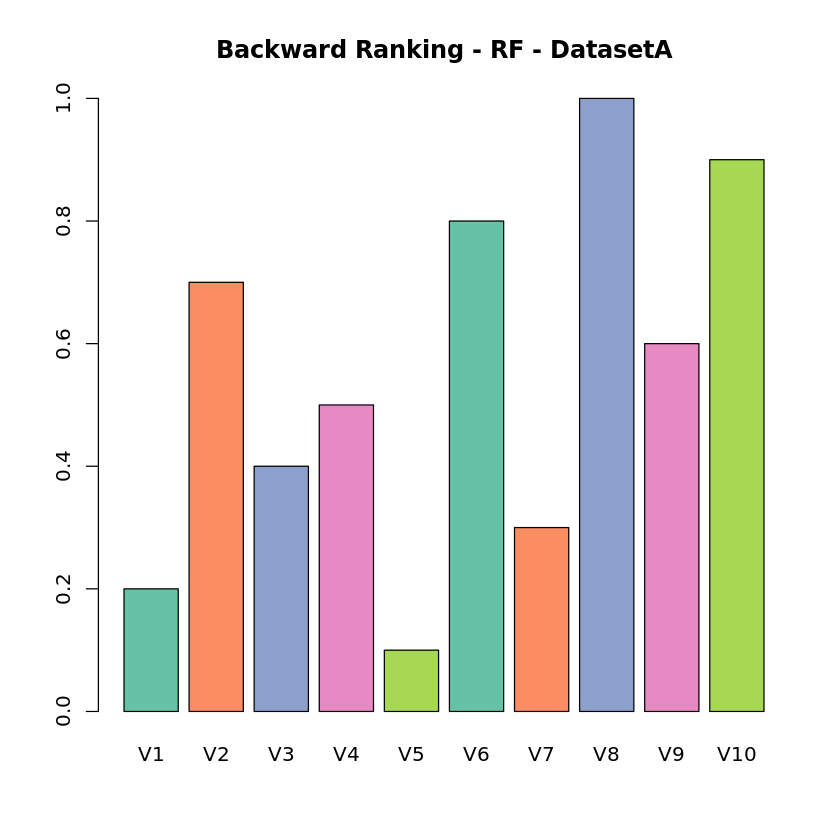

In [ ]:
graficar_valores(datos.lda, "Backward Ranking - LDA - DatasetA")
graficar_valores(datos.svm, "Backward Ranking - SVM - DatasetA")
graficar_valores(datos.bw, "Backward Ranking - RF - DatasetA")


#### Dataset B

In [ ]:
# LDA
datos_B.lda <- backward.ranking(datosB.x, datosB.y, method="lda.est")
# SVM
invisible(capture.output(datos_B.svm <- backward.ranking(datosB.x, datosB.y, method="svm.est")))
# Random Forest
datos_B.bw <- backward.ranking(datosB.x, datosB.y, method="rf.est")

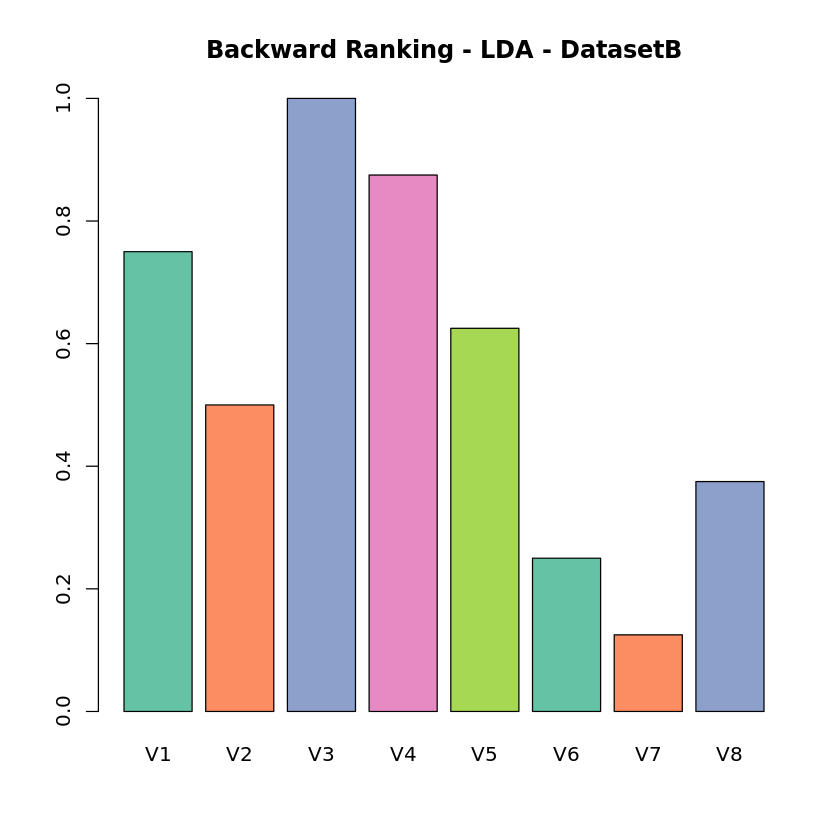

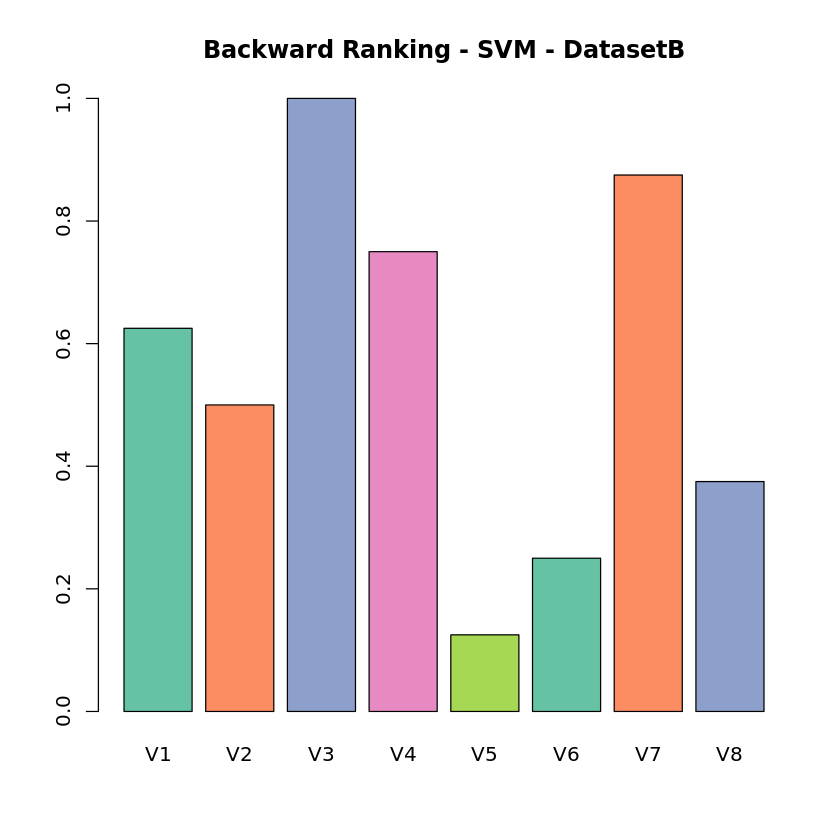

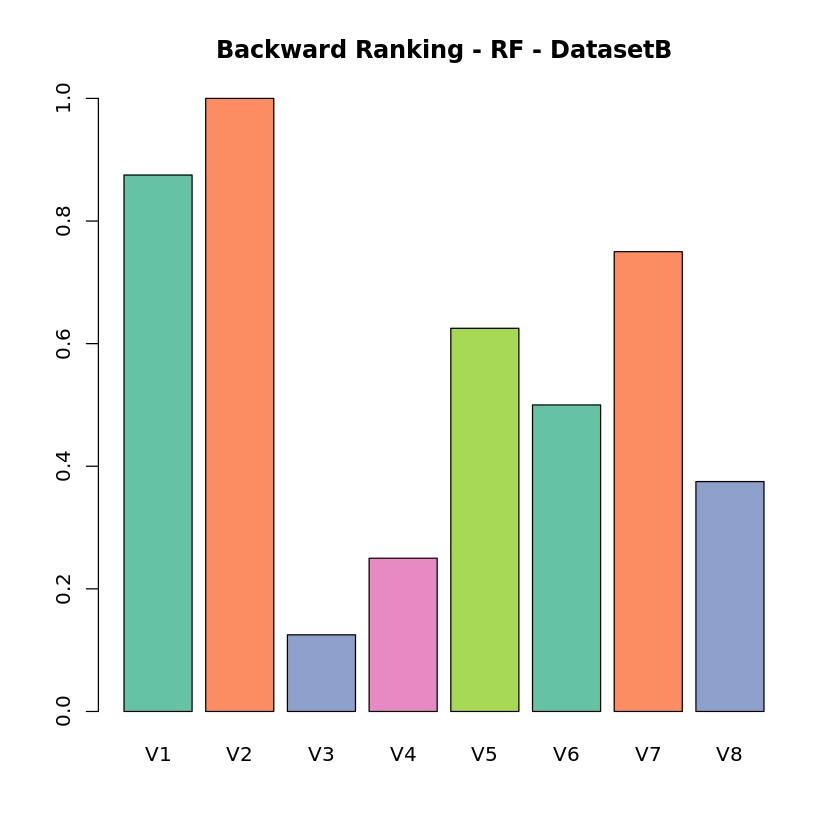

In [ ]:
graficar_valores(datos_B.lda, "Backward Ranking - LDA - DatasetB")
graficar_valores(datos_B.svm, "Backward Ranking - SVM - DatasetB")
graficar_valores(datos_B.bw, "Backward Ranking - RF - DatasetB")

### Kruskal

#### Dataset A

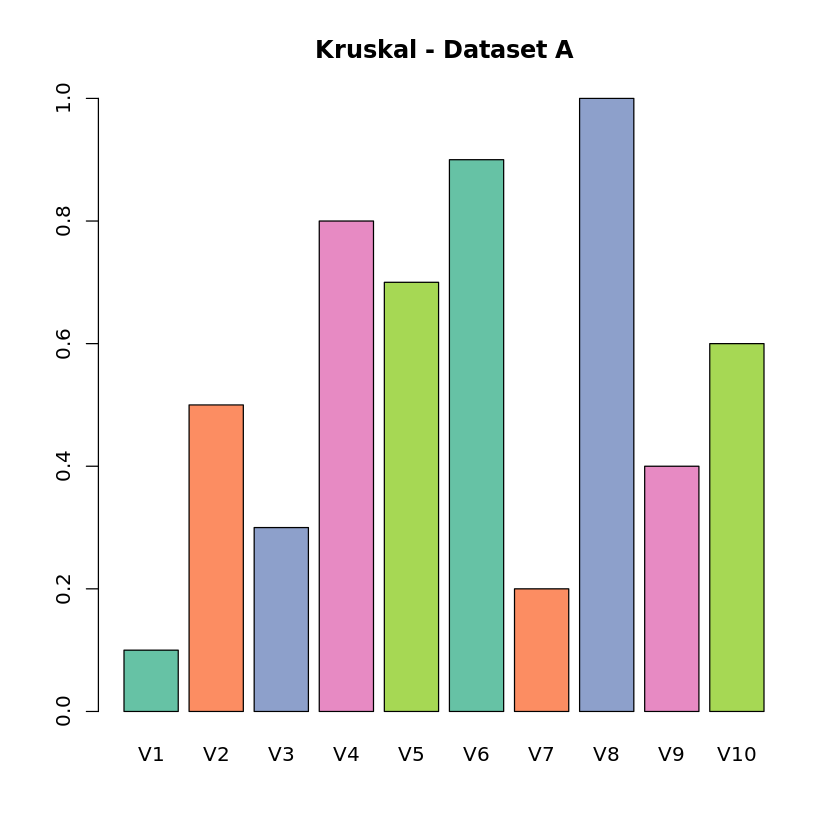

In [ ]:
datos_kruskal_A <- kruskal.ranking(datosA.x, datosA.y)
graficar_valores(datos_kruskal_A, "Kruskal - Dataset A")

#### Dataset B

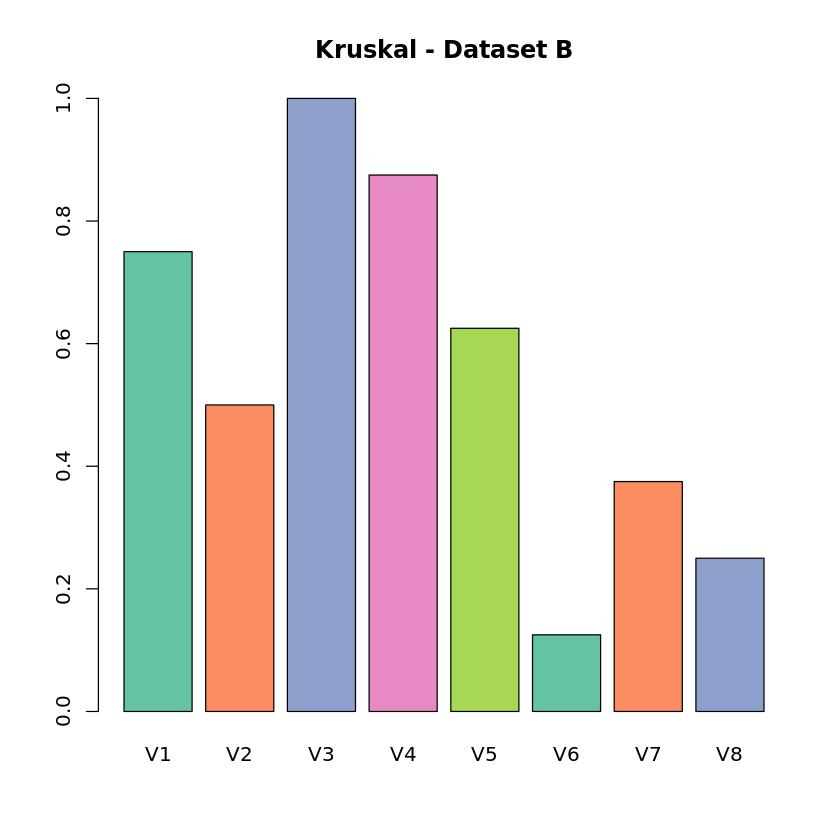

In [ ]:
datos_kruskal_B <- kruskal.ranking(datosB.x, datosB.y)
graficar_valores(datos_kruskal_B, "Kruskal - Dataset B")

### RFE con distintas funciones

#### Dataset A

In [ ]:
datos.rfe.rf <- rfe.ranking(datosA.x, datosA.y, method="imp.rf")
invisible(capture.output(datos.rfe.linsvm <- rfe.ranking(datosA.x, datosA.y, method="imp.linsvm")))

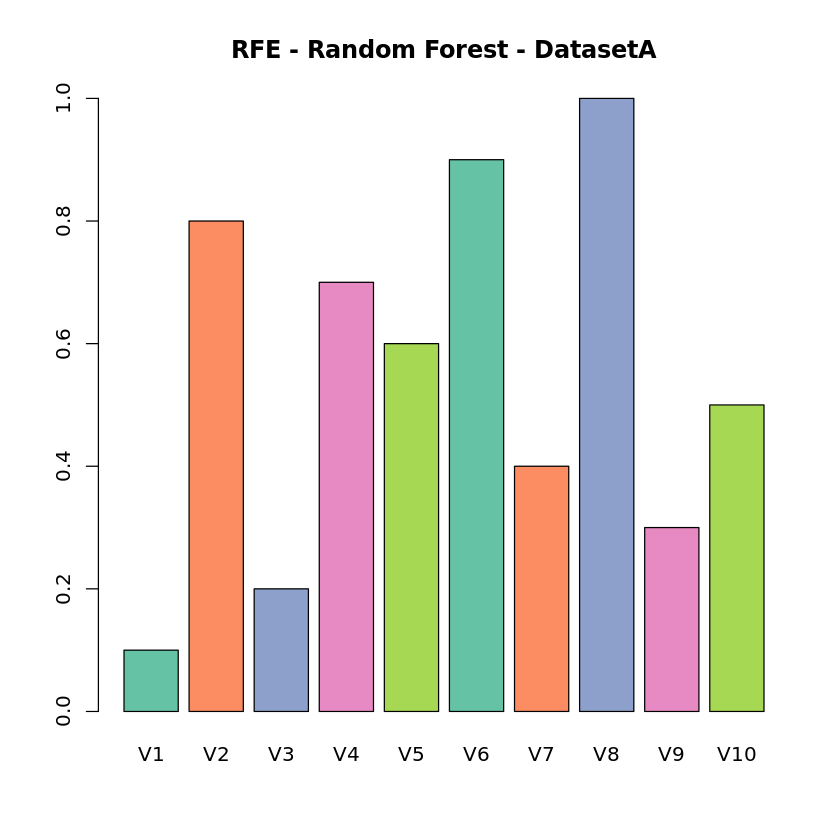

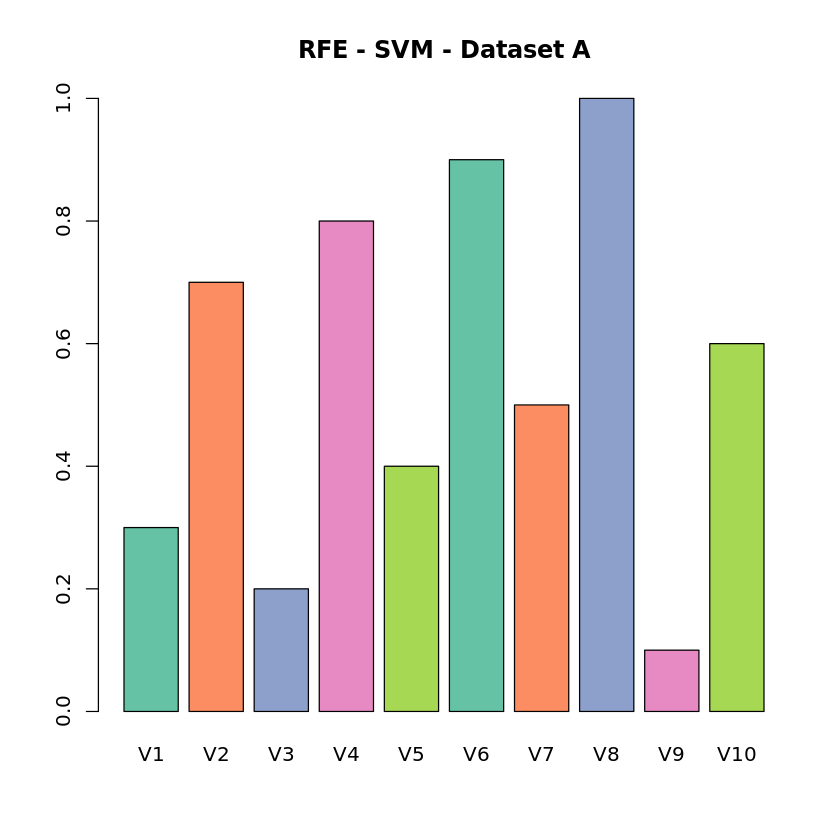

In [ ]:
graficar_valores(datos.rfe.rf, "RFE - Random Forest - DatasetA")
graficar_valores(datos.rfe.linsvm, "RFE - SVM - Dataset A")

#### Dataset B

In [ ]:
datos.rfe.rf_B <- rfe.ranking(datosB.x, datosB.y, method="imp.rf")
invisible(capture.output(datos.rfe.linsvm_B <- rfe.ranking(datosB.x, datosB.y, method="imp.linsvm")))

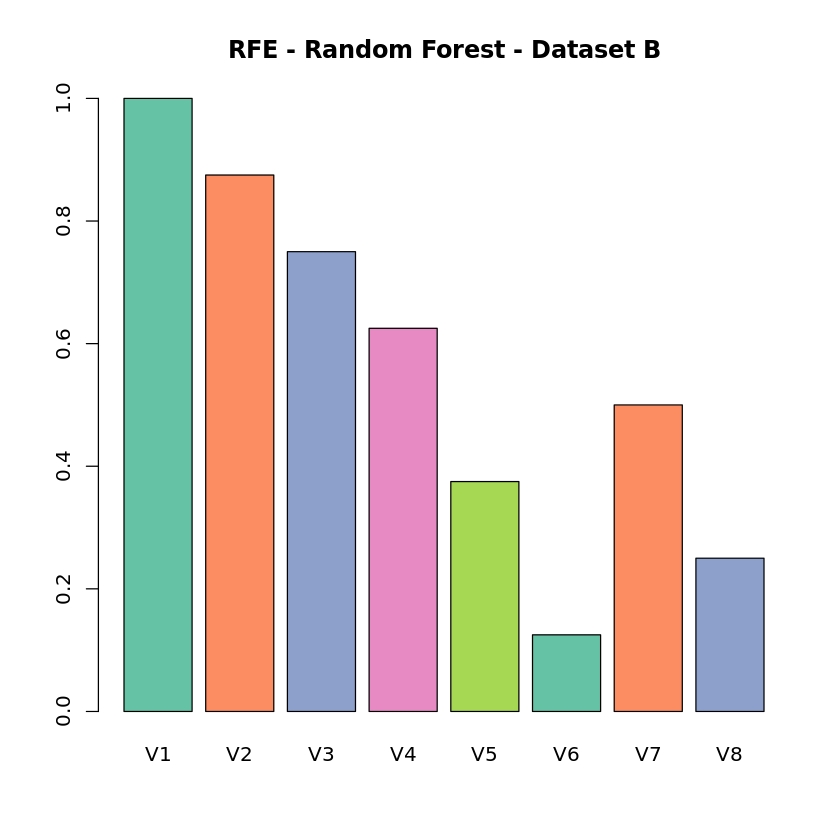

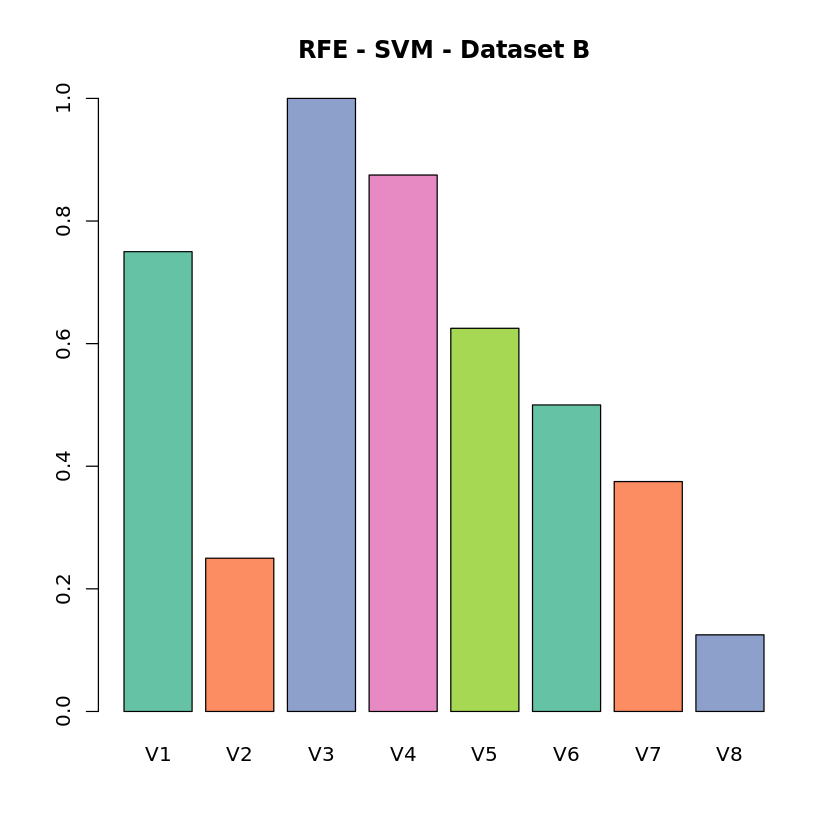

In [ ]:
graficar_valores(datos.rfe.rf_B, "RFE - Random Forest - Dataset B")
graficar_valores(datos.rfe.linsvm_B, "RFE - SVM - Dataset B")

### Forward Ranking

#### Dataset A

In [ ]:
# LDA
fw.datos.lda <- forward.ranking(datosA.x, datosA.y, method="lda.est")
# SVM
invisible(capture.output(fw.datos.svm <- forward.ranking(datosA.x, datosA.y, method="svm.est")))
# Random Forest
fw.datos.bw <- forward.ranking(datosA.x, datosA.y, method="rf.est")

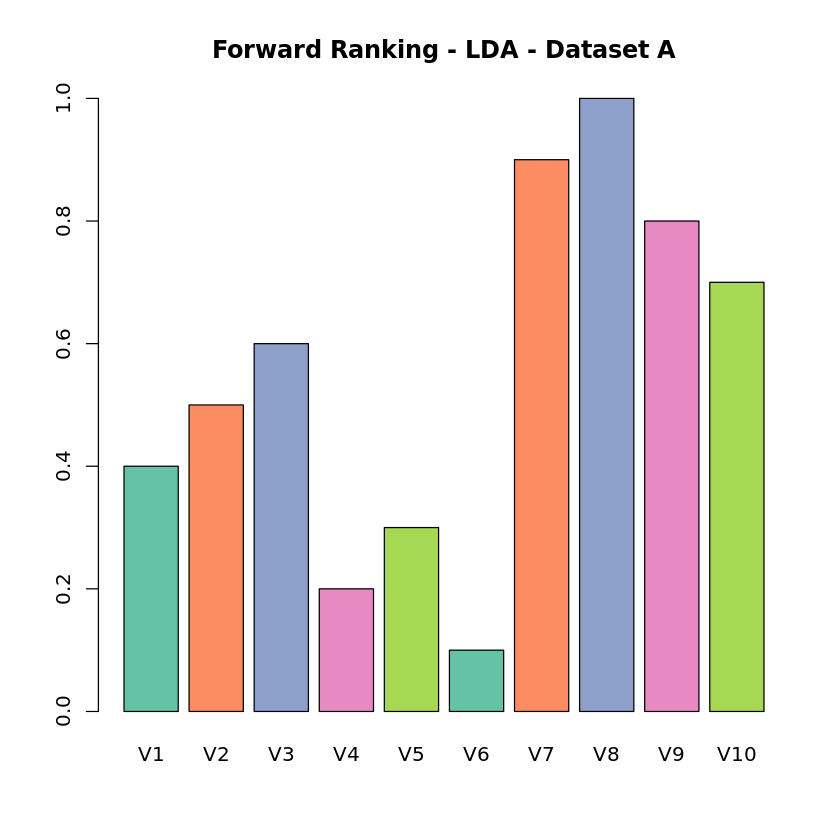

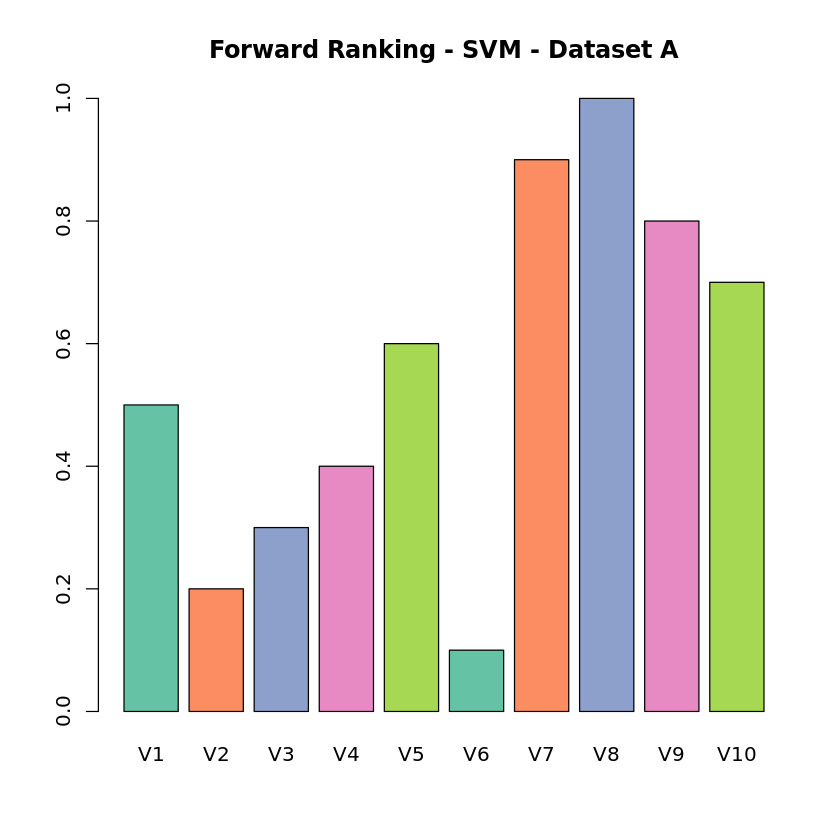

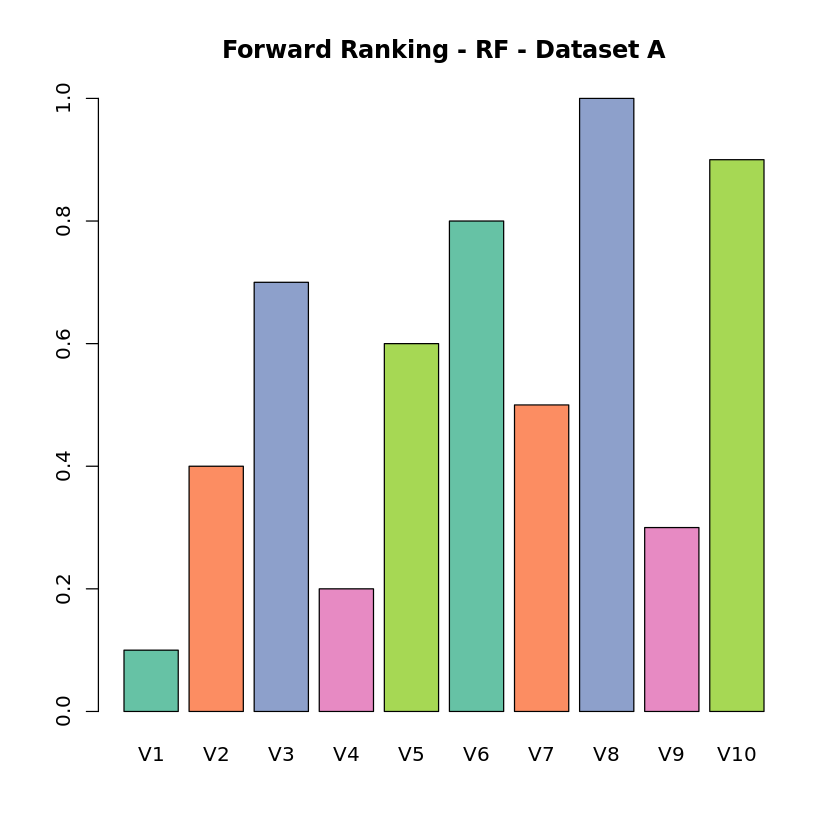

In [ ]:
graficar_valores(fw.datos.lda, "Forward Ranking - LDA - Dataset A")
graficar_valores(fw.datos.svm, "Forward Ranking - SVM - Dataset A")
graficar_valores(fw.datos.bw, "Forward Ranking - RF - Dataset A")

#### Dataset B

In [ ]:
# LDA
fw.datos.lda_B <- forward.ranking(datosB.x, datosB.y, method="lda.est")
# SVM
invisible(capture.output(fw.datos.svm_B <- forward.ranking(datosB.x, datosB.y, method="svm.est")))
# Random Forest
fw.datos.bw_B <- forward.ranking(datosB.x, datosB.y, method="rf.est")

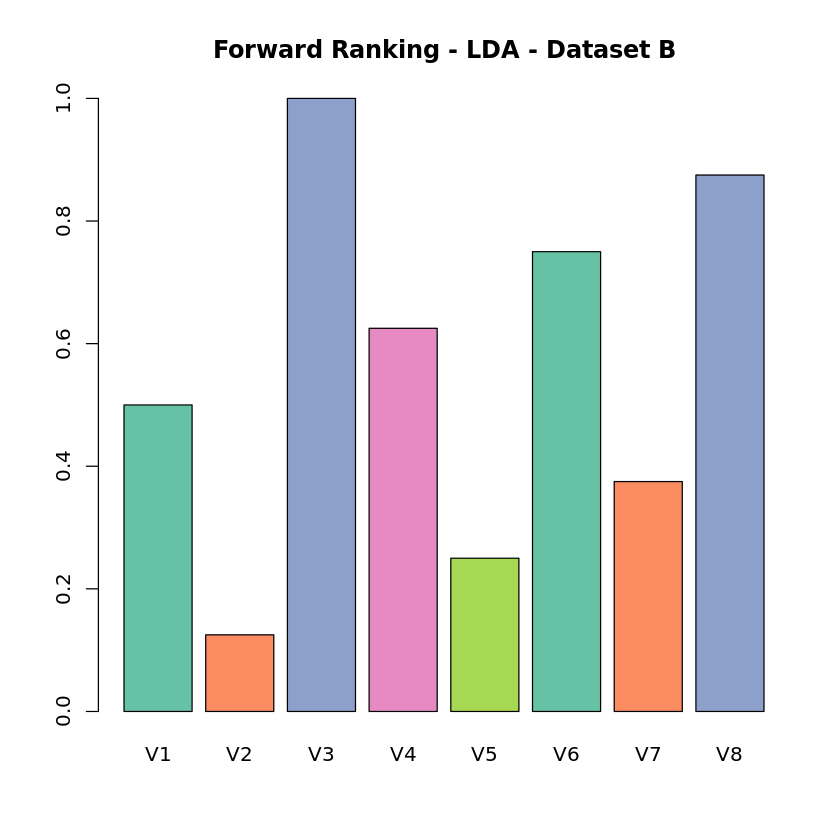

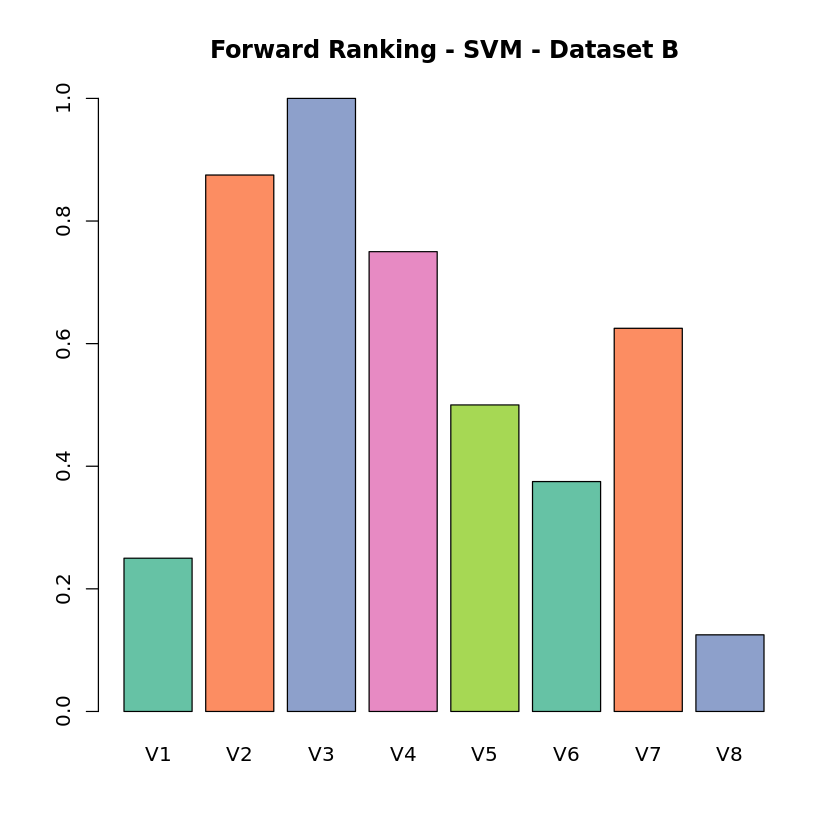

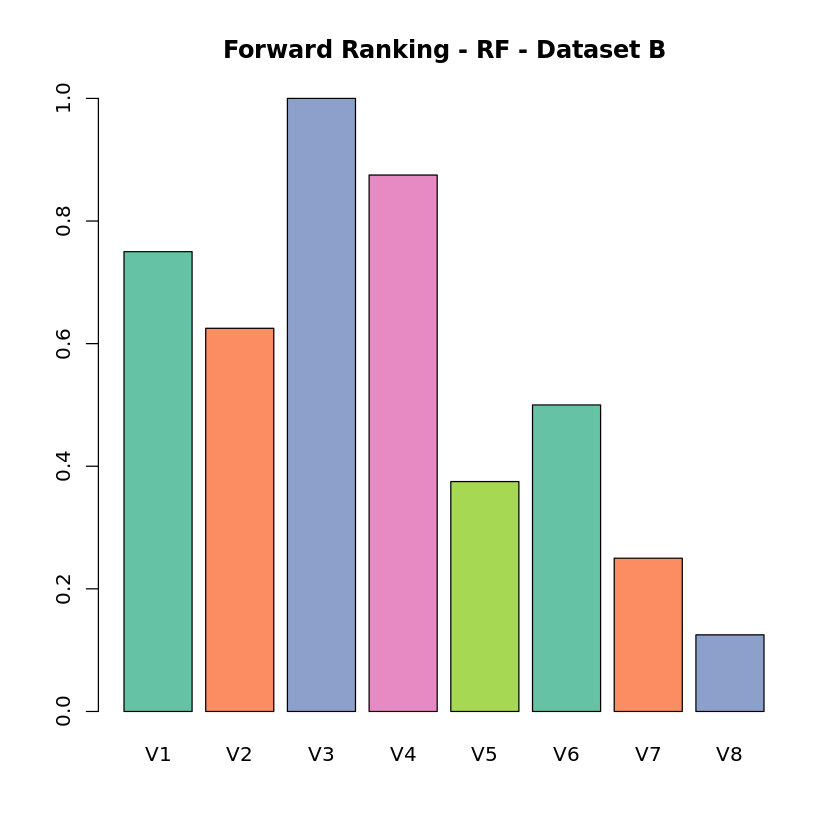

In [ ]:
graficar_valores(fw.datos.lda_B, "Forward Ranking - LDA - Dataset B")
graficar_valores(fw.datos.svm_B, "Forward Ranking - SVM - Dataset B")
graficar_valores(fw.datos.bw_B, "Forward Ranking - RF - Dataset B")

## Ejercicio 3

In [ ]:
#  Código del TP1 para el problema del diagonal

generar_diagonal <- function(n, d, C){
  # Centros
  center0 = rep(-1, times=d)
  center1 = rep(1, times=d)

  ## Matriz diagonal de desviación estándar
  desviacion = C * sqrt(d)
  matriz = diag(rep(desviacion, times=d))

  ## Generamos los puntos aleatorios y construimos el dataframe
  points0 = mvrnorm(floor(n / 2), center0, matriz)
  points1 = mvrnorm(ceiling(n / 2), center1, matriz)

  clase0 = cbind(points0, rep(0, times=floor(n / 2)))
  clase1 = cbind(points1, rep(1, times=ceiling(n / 2)))

  return(as.data.frame(rbind(clase0, clase1)))

}

In [ ]:
# Funcion auxiliar para arreglar los nombres de las columnas al agregar las
# variables de ruido al dataset del diagonal

nombrar_columnas <- function(from, size){ # 11 90
    colnames <- c()
    for(i in 0 : size){
        colnames[i] <- paste("V", as.character(from + i), sep="")
    }
    return(colnames)
}

In [ ]:
dataset.diagonal <- generar_diagonal(100, 10, 2)
x <- dataset.diagonal[, -11]
y <- dataset.diagonal[, 11]

# Generamos variables con ruido uniforme y las agregamos al dataset
ruido <- crea.ruido.unif(100, 90)
colnames(ruido) <- c(nombrar_columnas(10, 90), 'y')
# Dataset mergeado con ruido
dataset.diagonal.ruidoso <- cbind(x, ruido)
# Guardamos cuales son las variables no ruidosas
original_variables <- colnames(dataset.diagonal.ruidoso)[1:10]

In [ ]:
contar_apariciones <- function(ranking.total, nombres){
    n <- 0
    primeras.diez <- ranking.total[1 : 10]
    for(i in 1 : length(nombres)){
        if(nombres[i] %in% primeras.diez){
            n <- n + 1
        }
    }
    return(n / 10)
}

In [ ]:
experimento <- function(method, method.args, ...){
    porcentajes <- c()
    for(i in 1:30){
      ranking <- do.call(method, c(method.args, list(...)))
      ranking.names <- ranking$ordered.names.list
      porcentajes[i] <- contar_apariciones(ranking.names, original_variables) 
    }
    promedio <- mean(porcentajes)
    return(list(porcentajes=porcentajes, promedio=promedio))
}

In [ ]:
mostrar_resultado <- function(resultado){
    porcentajes <- resultado$porcentajes
    promedio <- resultado$promedio
    print("Porcentajes en cada iteración:")
    cat(porcentajes, "\n")
    print("Porcentaje promedio final:")
    cat(promedio, "\n")
}

In [ ]:
# Kruskal
resultado.kruskal <- experimento(method="kruskal.ranking", list(dataset.diagonal.ruidoso[, -101], dataset.diagonal.ruidoso[, 101]))

In [ ]:
mostrar_resultado(resultado.kruskal)

[1] "Porcentajes en cada iteración:"
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
[1] "Porcentaje promedio final:"
0 


In [ ]:
# RFE con Random Forest
resultado.rfe <- experimento(method="rfe.ranking", list(dataset.diagonal.ruidoso[, -101], dataset.diagonal.ruidoso[, 101], "imp.rf"))

In [ ]:
mostrar_resultado(resultado.rfe)

[1] "Porcentajes en cada iteración:"
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
[1] "Porcentaje promedio final:"
0 


In [ ]:
# Backward ranking con Random Forest
resultado.bw <- experimento(method="backward.ranking", list(dataset.diagonal.ruidoso[, -101], dataset.diagonal.ruidoso[, 101], "svm.est"))

In [ ]:
mostrar_resultado(resultado.bw)

[1] "Porcentajes en cada iteración:"
0 0 0 0 0 0 0 0 0 0 0.1 0.1 0.1 0 0 0.1 0 0 0.1 0 0 0 0 0.1 0 0 0 0 0 0 
[1] "Porcentaje promedio final:"
0.02 


In [ ]:
# Forward ranking con Random Forest
resultado.fw <- experimento(method="forward.ranking", list(dataset.diagonal.ruidoso[, -101], dataset.diagonal.ruidoso[, 101], "rf.est"))

In [ ]:
mostrar_resultado(resultado.fw)

[1] "Porcentajes en cada iteración:"
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.1 0 0.1 
[1] "Porcentaje promedio final:"
0.006666667 


## Ejercicio 4

Para este ejercicio elegimos un dataset obtenido de [este link](https://www.kaggle.com/datasets/kandij/diabetes-dataset). El objetivo de este dataset es usarlo para predecir si un paciente tiene diabetes basado en determinados factores:

- Número de embarazos.
- Nivel de glucosa.
- Presión sanguínea.
- Grosor de la piel.
- Insulina.
- BMI: índice de masa muscular.
- Diabetes Pedigree Function.
- Edad.

Un resultado lógico esperado sería que variables como 'glucosa' e 'insulina' salgan como una de las más rankeadas ya que sabemos que son influyentes. Veremos si esto es así a continuación.

In [10]:
diabetes.dataset <- read.csv("/home/diabetes.csv") # /home/diabetes.csv
# Mostramos las primeras 5 columnas del dataset a modo de ejemplo
diabetes.dataset[1:5, ]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


In [11]:
diabetes.dataset.x <- diabetes.dataset[, -9]
diabetes.dataset.y <- diabetes.dataset[, 9]


A continuación mostramos el biplot de nuestro dataset.

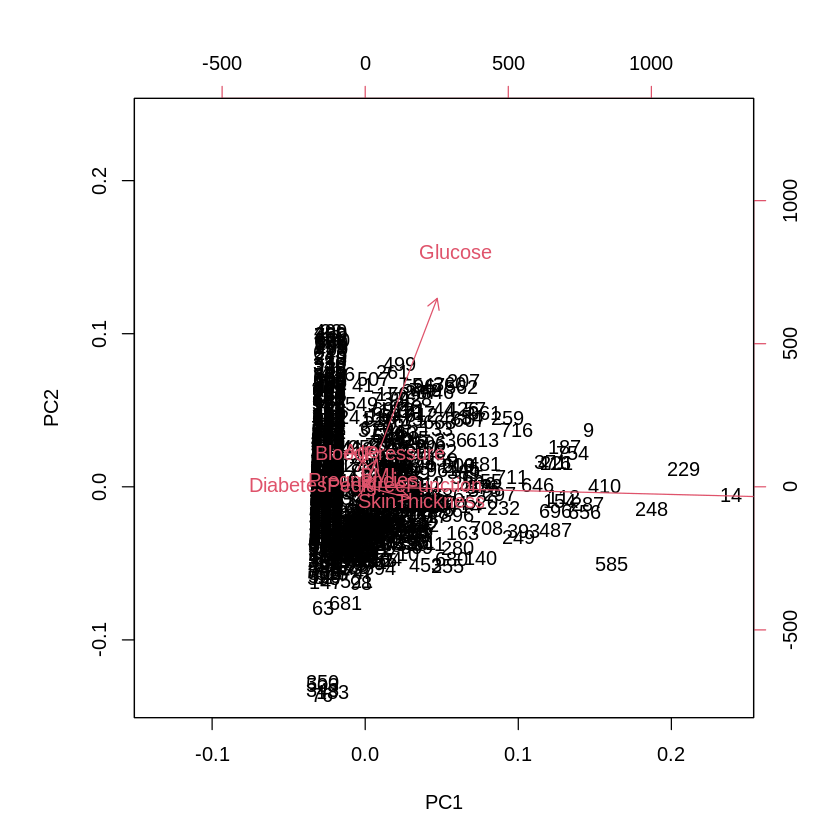

In [12]:
diabetes.dataset.pca <- prcomp(diabetes.dataset.x)
biplot(diabetes.dataset.pca, expand=2.5)

No se que quiere decir esto la verdad.

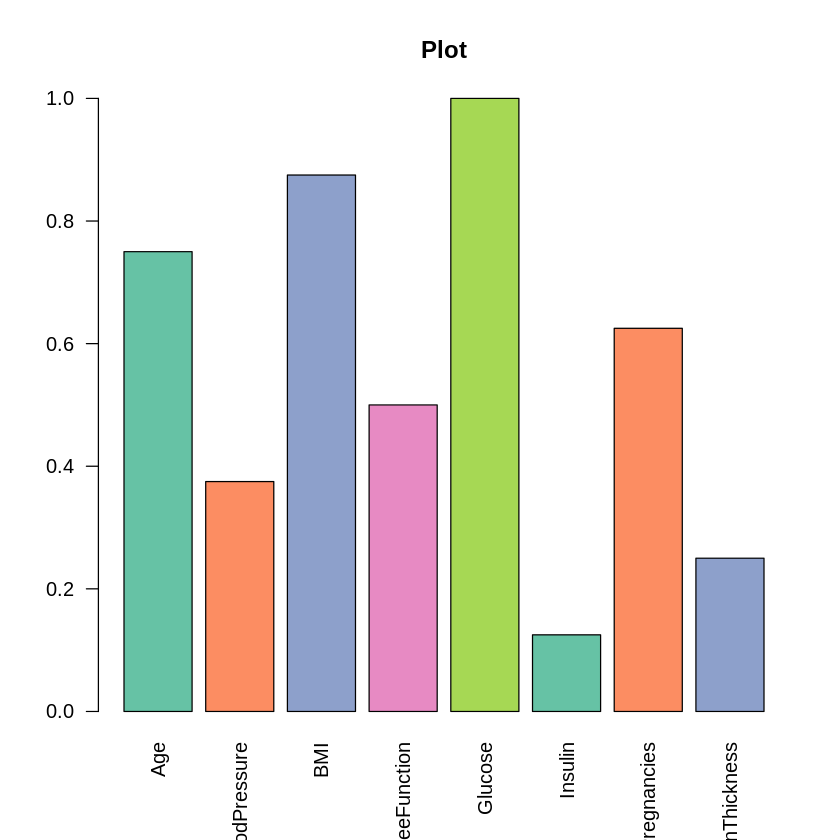

In [19]:
# Utilizamos el método de Kruskal para seleccionar variables.

result <- kruskal.ranking(diabetes.dataset.x, diabetes.dataset.y)
graficar_valores(result)

Podemos ver que salió como la variable 'más imporante' la Glucosa, lo cual era una de las cosas que esperábamos, mientras que la Insulina es la más baja. Por otro lado, vemos que el BMI es otra de las características más importantes que no habíamos previsto antes de hacer el análisis.